Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large\\A', 'notMNIST_large\\B', 'notMNIST_large\\C', 'notMNIST_large\\D', 'notMNIST_large\\E', 'notMNIST_large\\F', 'notMNIST_large\\G', 'notMNIST_large\\H', 'notMNIST_large\\I', 'notMNIST_large\\J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small\\A', 'notMNIST_small\\B', 'notMNIST_small\\C', 'notMNIST_small\\D', 'notMNIST_small\\E', 'notMNIST_small\\F', 'notMNIST_small\\G', 'notMNIST_small\\H', 'notMNIST_small\\I', 'notMNIST_small\\J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [5]:
def file_sample_display(folders):
    for folder in folders:
        image_files = os.listdir(folder)    
        random_image_index = np.random.randint(len(image_files))
        random_image_file = os.path.join(folder, image_files[random_image_index])   
        display(folder, Image(random_image_file))
        
file_sample_display(train_folders)
file_sample_display(test_folders)

'notMNIST_large\\A'

'notMNIST_large\\B'

'notMNIST_large\\C'

'notMNIST_large\\D'

'notMNIST_large\\E'

'notMNIST_large\\F'

'notMNIST_large\\G'

'notMNIST_large\\H'

'notMNIST_large\\I'

'notMNIST_large\\J'

'notMNIST_small\\A'

'notMNIST_small\\B'

'notMNIST_small\\C'

'notMNIST_small\\D'

'notMNIST_small\\E'

'notMNIST_small\\F'

'notMNIST_small\\G'

'notMNIST_small\\H'

'notMNIST_small\\I'

'notMNIST_small\\J'

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large\A.pickle already present - Skipping pickling.
notMNIST_large\B.pickle already present - Skipping pickling.
notMNIST_large\C.pickle already present - Skipping pickling.
notMNIST_large\D.pickle already present - Skipping pickling.
notMNIST_large\E.pickle already present - Skipping pickling.
notMNIST_large\F.pickle already present - Skipping pickling.
notMNIST_large\G.pickle already present - Skipping pickling.
notMNIST_large\H.pickle already present - Skipping pickling.
notMNIST_large\I.pickle already present - Skipping pickling.
notMNIST_large\J.pickle already present - Skipping pickling.
notMNIST_small\A.pickle already present - Skipping pickling.
notMNIST_small\B.pickle already present - Skipping pickling.
notMNIST_small\C.pickle already present - Skipping pickling.
notMNIST_small\D.pickle already present - Skipping pickling.
notMNIST_small\E.pickle already present - Skipping pickling.
notMNIST_small\F.pickle already present - Skipping pickling.
notMNIST_small\G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.


---

Some random letters from the notMNIST_small\A.pickle


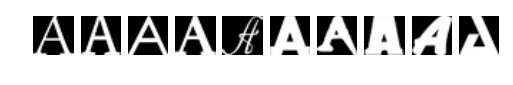

Some random letters from the notMNIST_small\B.pickle


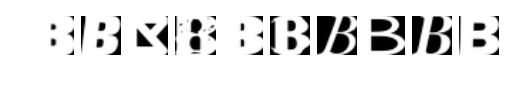

Some random letters from the notMNIST_small\C.pickle


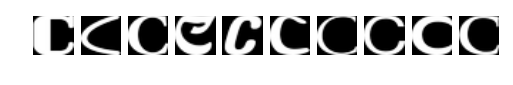

Some random letters from the notMNIST_small\D.pickle


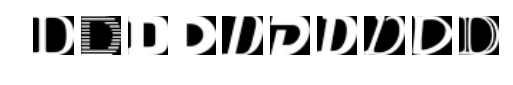

Some random letters from the notMNIST_small\E.pickle


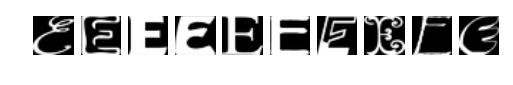

Some random letters from the notMNIST_small\F.pickle


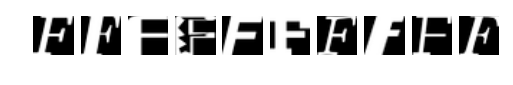

Some random letters from the notMNIST_small\G.pickle


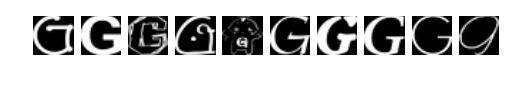

Some random letters from the notMNIST_small\H.pickle


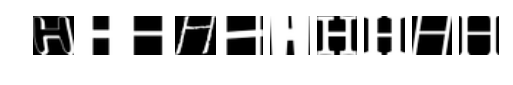

Some random letters from the notMNIST_small\I.pickle


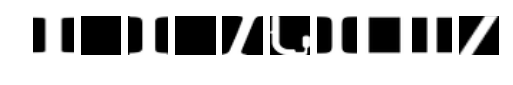

Some random letters from the notMNIST_small\J.pickle


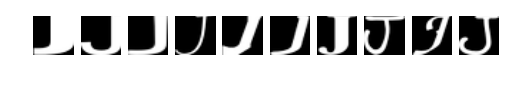

Some random letters from the notMNIST_large\A.pickle


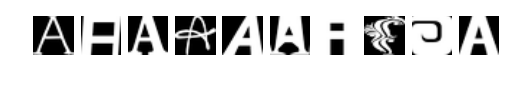

Some random letters from the notMNIST_large\B.pickle


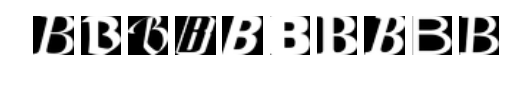

Some random letters from the notMNIST_large\C.pickle


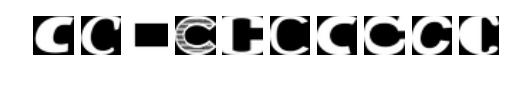

Some random letters from the notMNIST_large\D.pickle


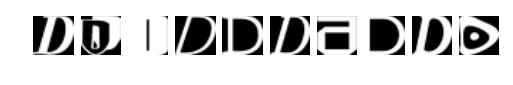

Some random letters from the notMNIST_large\E.pickle


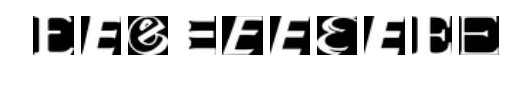

Some random letters from the notMNIST_large\F.pickle


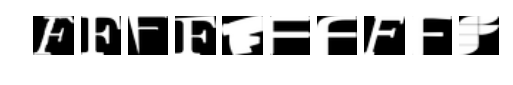

Some random letters from the notMNIST_large\G.pickle


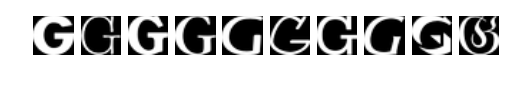

Some random letters from the notMNIST_large\H.pickle


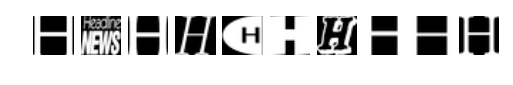

Some random letters from the notMNIST_large\I.pickle


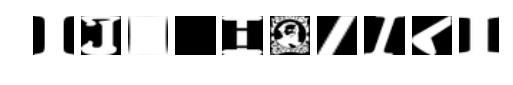

Some random letters from the notMNIST_large\J.pickle


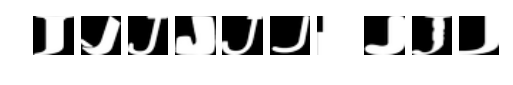

In [53]:
def show_letters(letters):
    fig = plt.figure()
    for i, letter in enumerate(letters):        
        ax = fig.add_subplot(1, len(letters), i + 1)
        ax.imshow(letter, cmap='Greys_r')
        ax.axis('off')            
    plt.show()
      
        
def letter_pickle_sample_display(datasets):   
    for letter_pickle_file in datasets:
        print("Some random letters from the " + letter_pickle_file)
        with open(letter_pickle_file, 'rb') as f:
            letter_set = pickle.load(f)                                                        
            random_indices = np.random.randint(0, letter_set.shape[0], 10)
            random_letters = letter_set[random_indices, :, :]  
            show_letters(random_letters)               
        
            
letter_pickle_sample_display(test_datasets)
letter_pickle_sample_display(train_datasets)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [8]:
def sample_num_display(datasets):  
    items_num = []
    for letter_pickle_file in datasets:
        with open(letter_pickle_file, 'rb') as f:
            letter_set = pickle.load(f)
            num = letter_set.shape[0]
            print(letter_pickle_file + ' %d letters' % num)
            items_num.append(num)           
            
sample_num_display(test_datasets)
sample_num_display(train_datasets)

notMNIST_small\A.pickle 1872 letters
notMNIST_small\B.pickle 1873 letters
notMNIST_small\C.pickle 1873 letters
notMNIST_small\D.pickle 1873 letters
notMNIST_small\E.pickle 1873 letters
notMNIST_small\F.pickle 1872 letters
notMNIST_small\G.pickle 1872 letters
notMNIST_small\H.pickle 1872 letters
notMNIST_small\I.pickle 1872 letters
notMNIST_small\J.pickle 1872 letters
notMNIST_large\A.pickle 52909 letters
notMNIST_large\B.pickle 52911 letters
notMNIST_large\C.pickle 52912 letters
notMNIST_large\D.pickle 52911 letters
notMNIST_large\E.pickle 52912 letters
notMNIST_large\F.pickle 52912 letters
notMNIST_large\G.pickle 52912 letters
notMNIST_large\H.pickle 52912 letters
notMNIST_large\I.pickle 52912 letters
notMNIST_large\J.pickle 52911 letters


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [9]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels


train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [10]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Letters in train dataset: 200000, labels: 200000
First labels:  ['E', 'J', 'G', 'C', 'H', 'D', 'F', 'J', 'G', 'E', 'H', 'G', 'A', 'B', 'I', 'A', 'B', 'J', 'G', 'F']


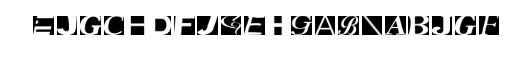

Labels 0 (A): 20000
Labels 1 (B): 20000
Labels 2 (C): 20000
Labels 3 (D): 20000
Labels 4 (E): 20000
Labels 5 (F): 20000
Labels 6 (G): 20000
Labels 7 (H): 20000
Labels 8 (I): 20000
Labels 9 (J): 20000

Letters in valid dataset: 10000, labels: 10000
First labels:  ['B', 'J', 'D', 'I', 'J', 'D', 'J', 'H', 'A', 'H', 'D', 'E', 'J', 'C', 'E', 'C', 'E', 'C', 'H', 'B']


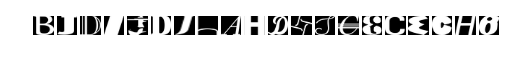

Labels 0 (A): 1000
Labels 1 (B): 1000
Labels 2 (C): 1000
Labels 3 (D): 1000
Labels 4 (E): 1000
Labels 5 (F): 1000
Labels 6 (G): 1000
Labels 7 (H): 1000
Labels 8 (I): 1000
Labels 9 (J): 1000

Letters in test dataset: 10000, labels: 10000
First labels:  ['D', 'G', 'E', 'H', 'H', 'H', 'H', 'B', 'H', 'E', 'G', 'A', 'J', 'A', 'A', 'C', 'C', 'I', 'C', 'J']


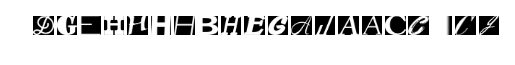

Labels 0 (A): 1000
Labels 1 (B): 1000
Labels 2 (C): 1000
Labels 3 (D): 1000
Labels 4 (E): 1000
Labels 5 (F): 1000
Labels 6 (G): 1000
Labels 7 (H): 1000
Labels 8 (I): 1000
Labels 9 (J): 1000



In [60]:
def alphabetic_label(i):
    return chr(ord('A') + i)

def shaffled_dataset_display(name, dataset, labels):
    samples = 20
    print("Letters in %s dataset: %d, labels: %d" % (name, len(dataset), len(labels)))
    print("First labels: ", end=' ')  
    print([alphabetic_label(i) for i in labels[0:samples]])
    show_letters(dataset[0:samples, :, :])
    
    total_labels = 0
    for i in range(10):
        s = np.count_nonzero(labels == i)
        print("Labels %d (%s): %d" % (i, alphabetic_label(i), s))
        total_labels += s

    if total_labels != len(labels):
        raise Exception('Verification error in ' + name + ' dataset')        
    print()
    
shaffled_dataset_display('train', train_dataset, train_labels)       
shaffled_dataset_display('valid', valid_dataset, valid_labels)
shaffled_dataset_display('test', test_dataset, test_labels)

Finally, let's save the data for later reuse:

In [12]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [13]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800512


0.995534095913 32 59
8 8


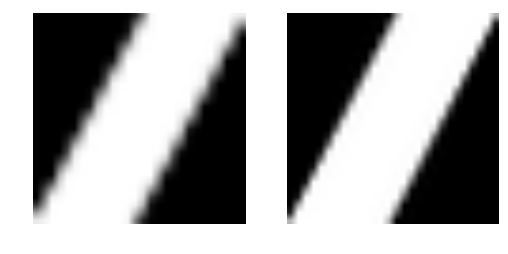

0.992302548606 32 726
8 8


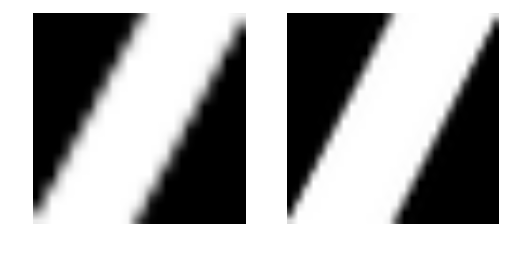

0.990755085833 59 163
8 8


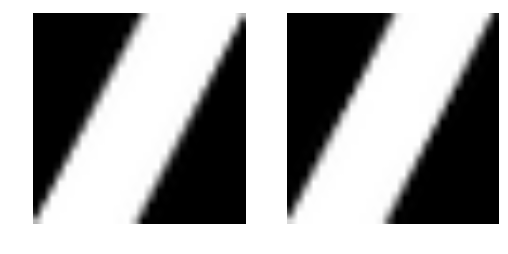

0.995065104682 59 726
8 8


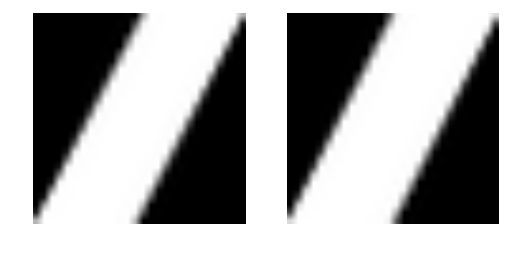

0.994641935453 100 223
8 8


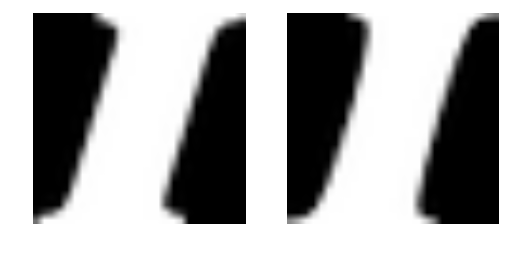

1.0 125 155
8 8


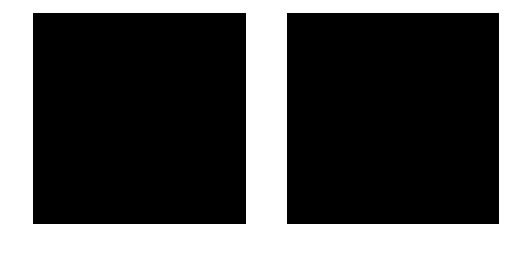

0.999311254011 125 264
8 8


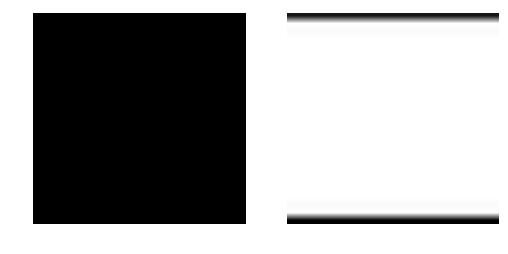

0.999955511623 125 307
8 8


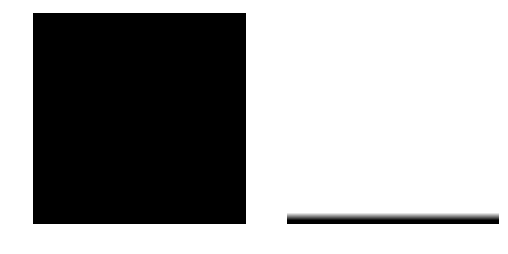

1.0 125 373
8 8


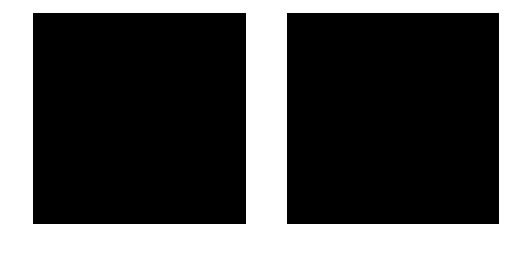

1.0 125 383
8 8


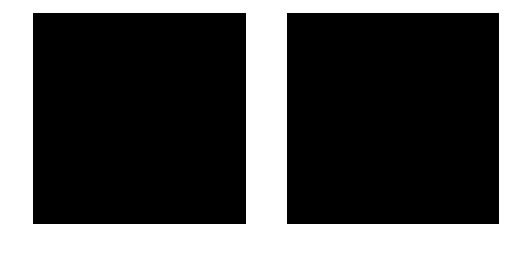

1.0 125 393
8 8


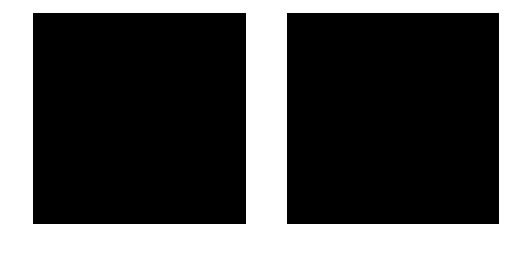

1.0 125 407
8 8


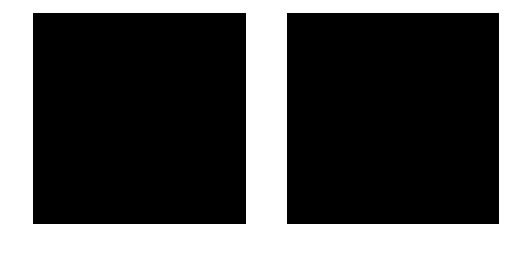

0.9995375406 125 625
8 8


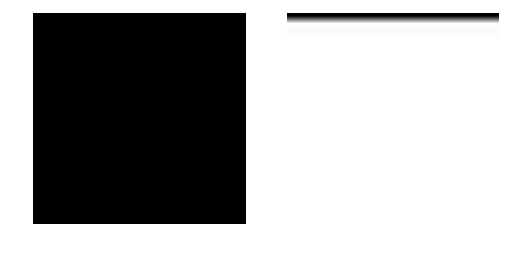

1.0 125 640
8 8


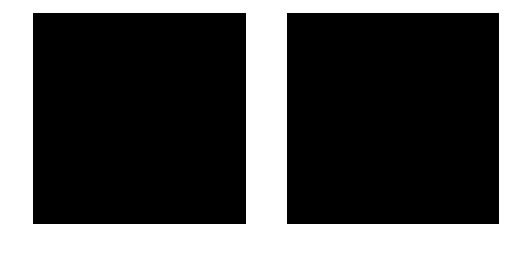

1.0 125 672
8 8


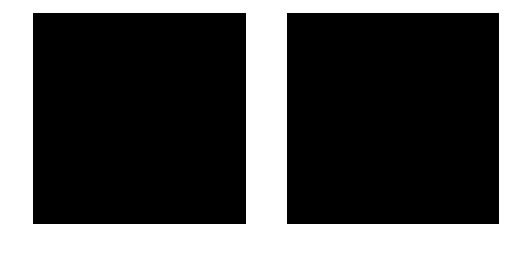

1.0 125 709
8 8


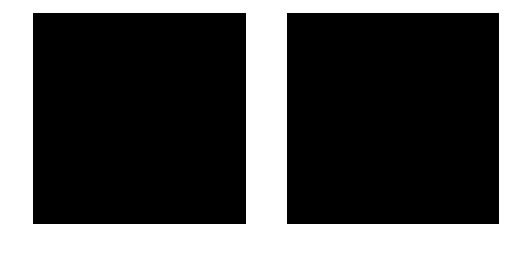

1.0 125 745
8 8


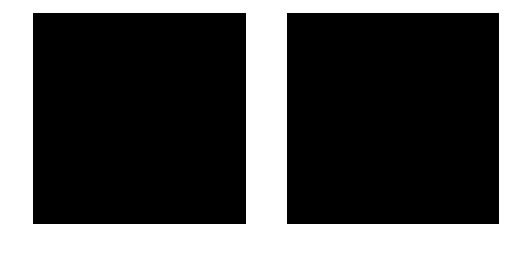

1.0 125 780
8 8


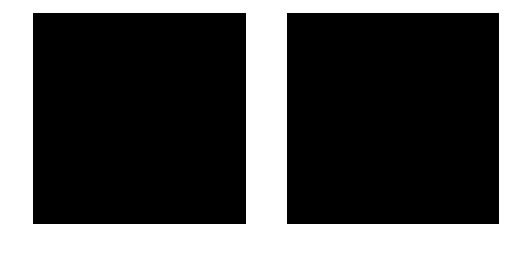

1.0 125 914
8 8


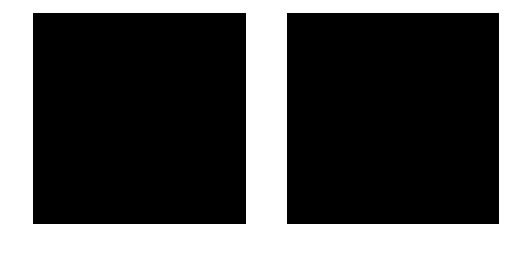

1.0 125 965
8 8


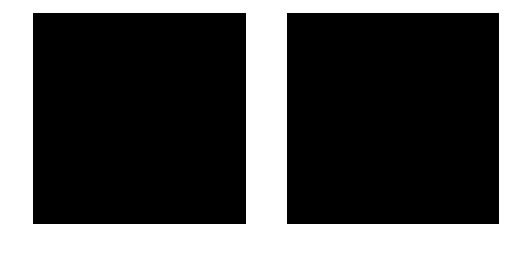

0.999311254011 155 264
8 8


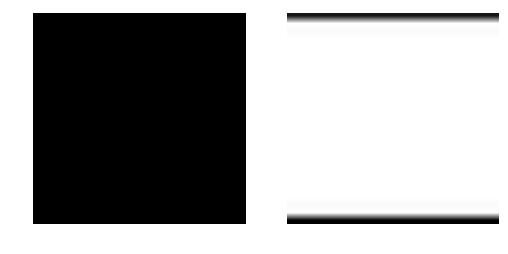

0.999955511623 155 307
8 8


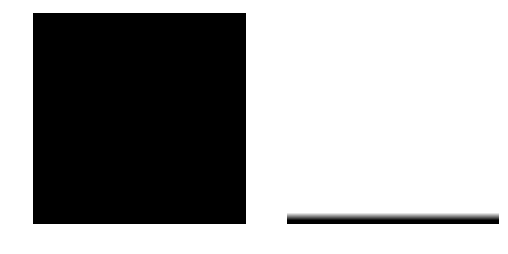

1.0 155 373
8 8


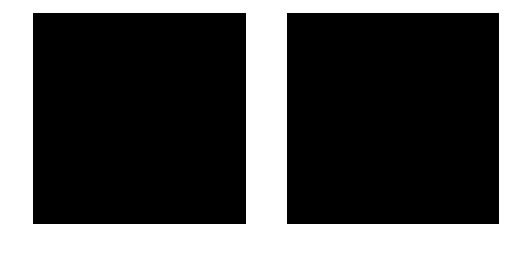

1.0 155 383
8 8


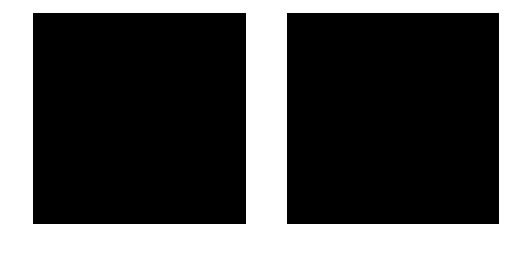

1.0 155 393
8 8


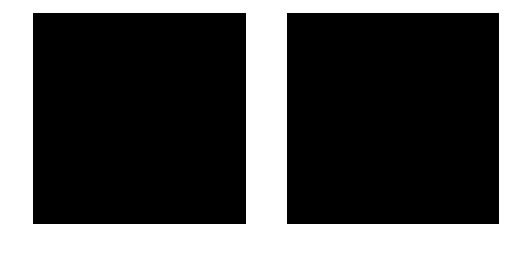

1.0 155 407
8 8


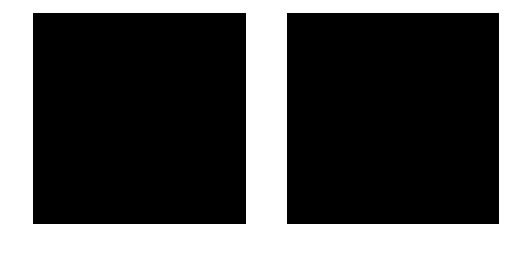

0.9995375406 155 625
8 8


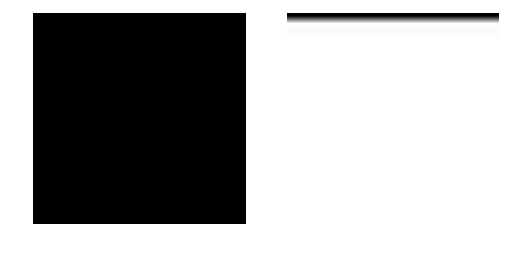

1.0 155 640
8 8


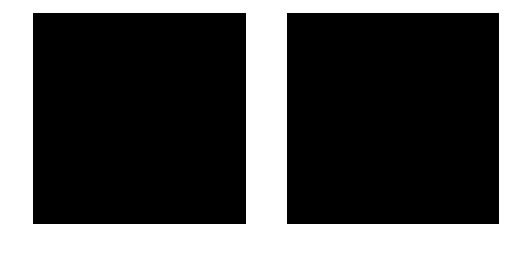

1.0 155 672
8 8


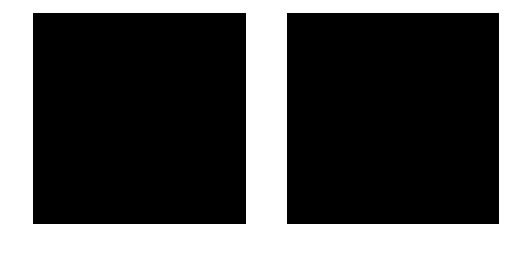

1.0 155 709
8 8


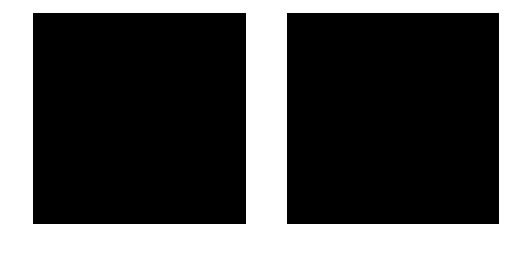

1.0 155 745
8 8


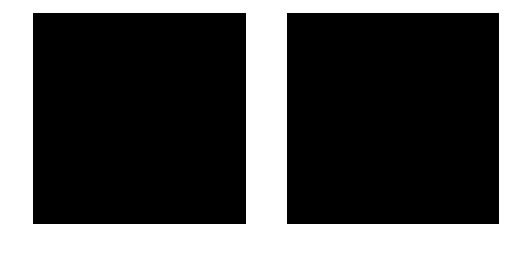

1.0 155 780
8 8


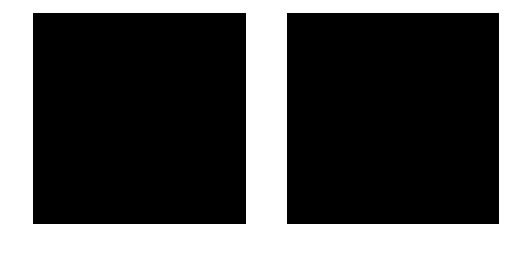

1.0 155 914
8 8


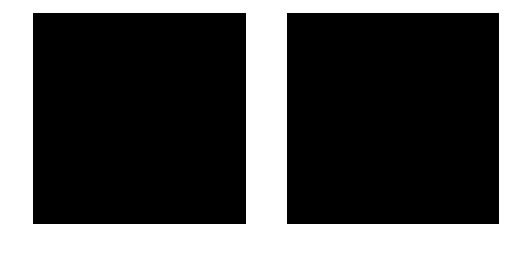

1.0 155 965
8 8


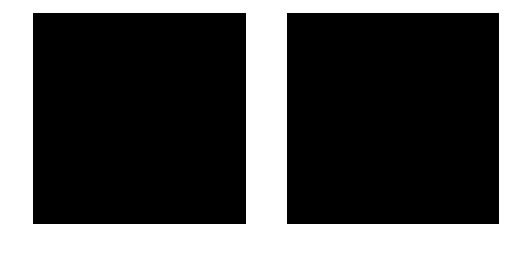

0.990080208518 185 910
1 1


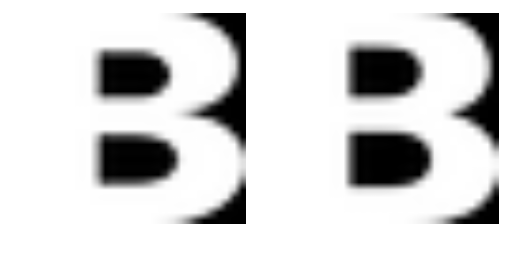

0.991124469787 262 291
7 1


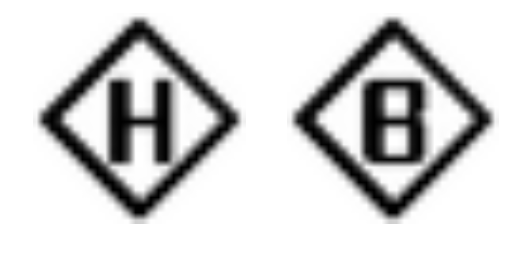

0.999523809587 264 307
8 8


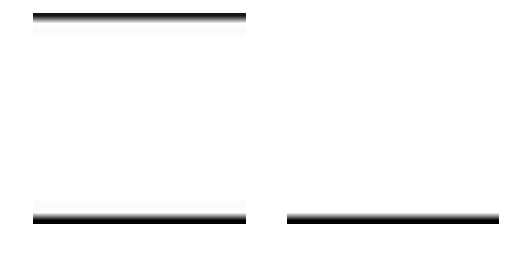

0.999311254011 264 373
8 8


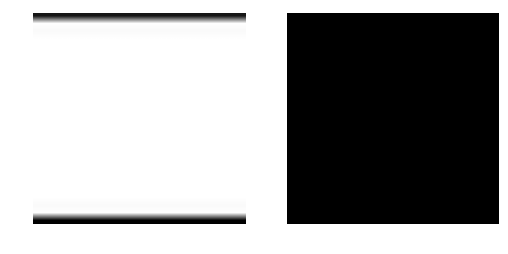

0.999311254011 264 383
8 8


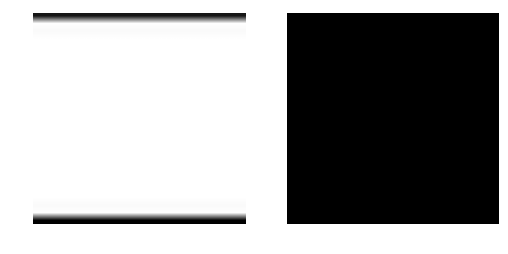

0.999311254011 264 393
8 8


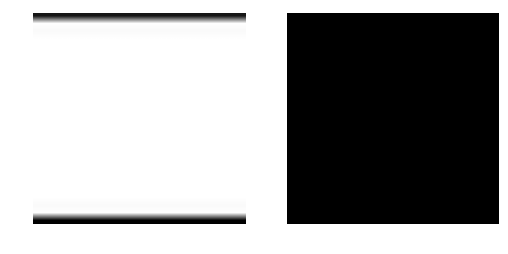

0.999311254011 264 407
8 8


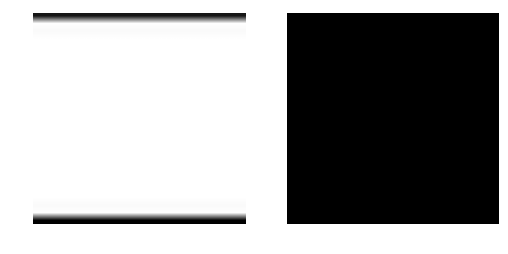

0.999614434084 264 625
8 8


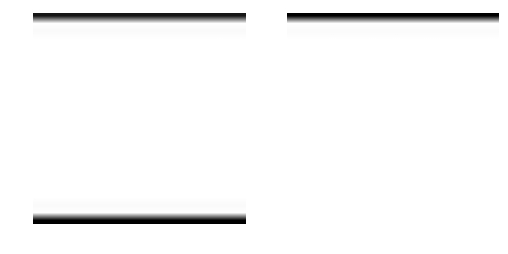

0.999311254011 264 640
8 8


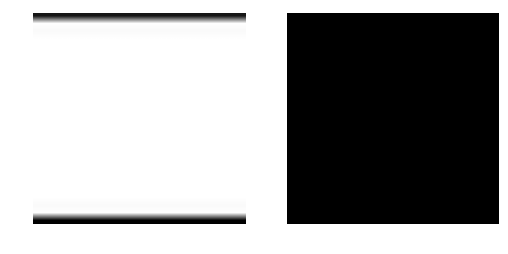

0.999311254011 264 672
8 8


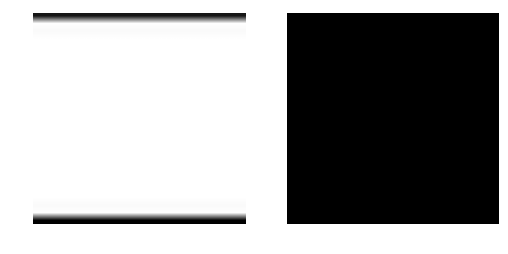

0.999311254011 264 709
8 8


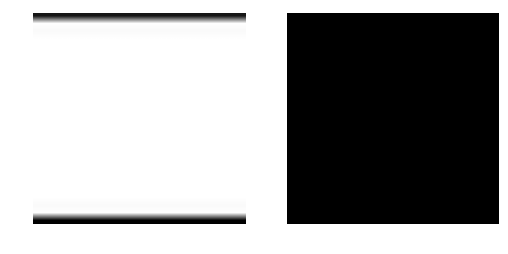

0.999311254011 264 745
8 8


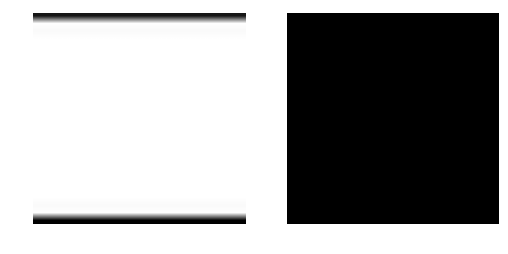

0.999311254011 264 780
8 8


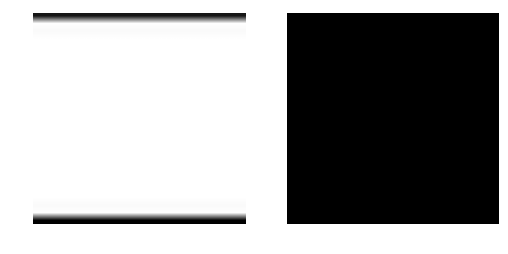

0.999311254011 264 914
8 8


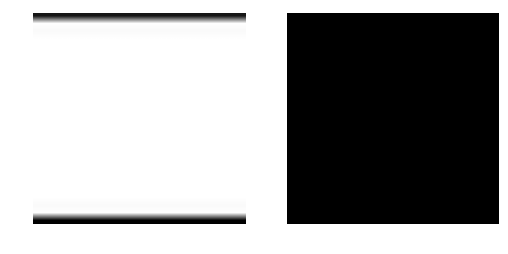

0.999311254011 264 965
8 8


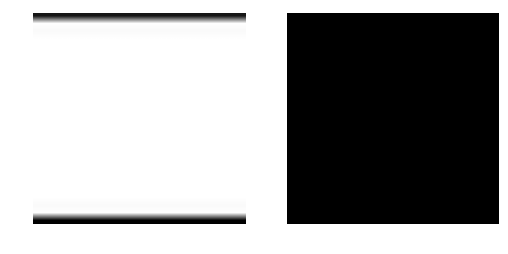

0.999955511623 307 373
8 8


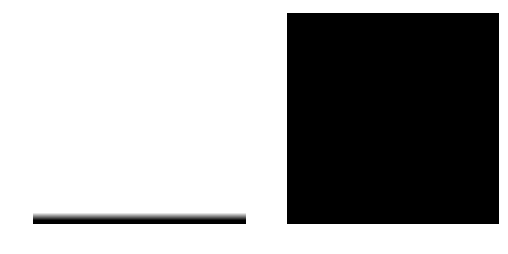

0.999955511623 307 383
8 8


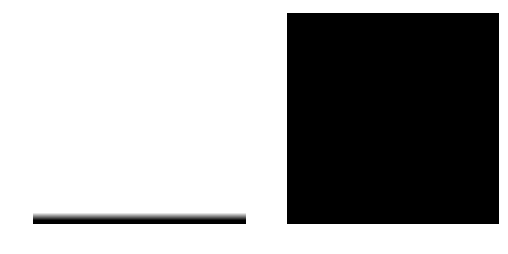

0.999955511623 307 393
8 8


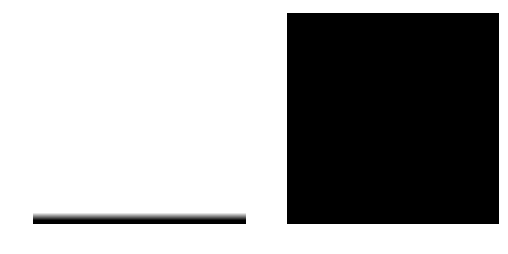

0.999955511623 307 407
8 8


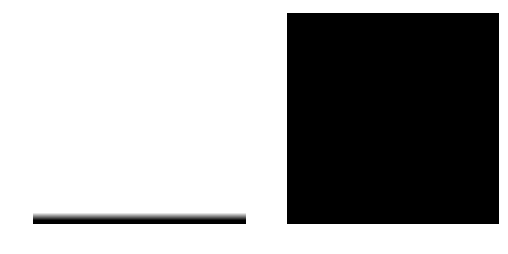

0.999493052252 307 625
8 8


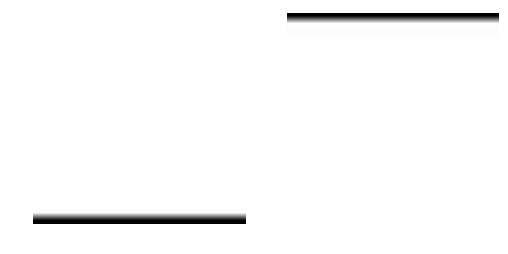

0.999955511623 307 640
8 8


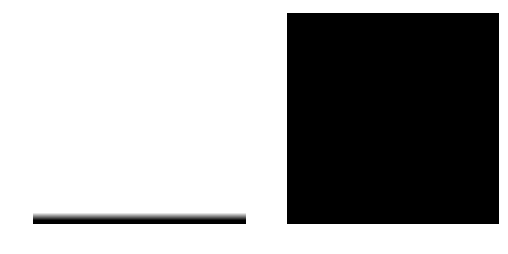

0.999955511623 307 672
8 8


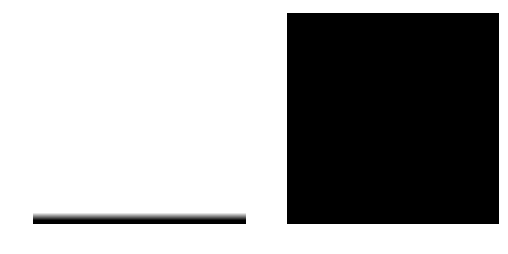

0.999955511623 307 709
8 8


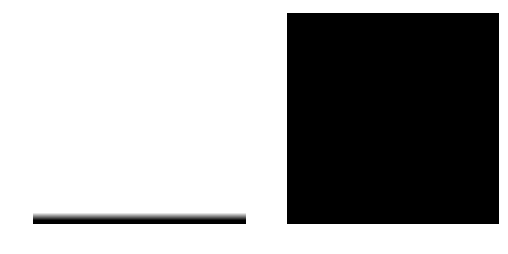

0.999955511623 307 745
8 8


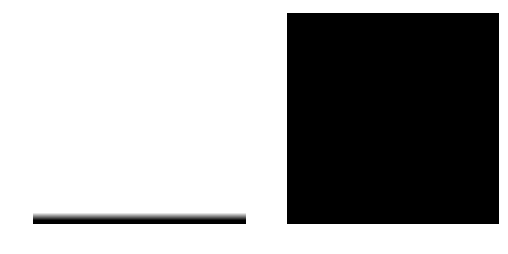

0.999955511623 307 780
8 8


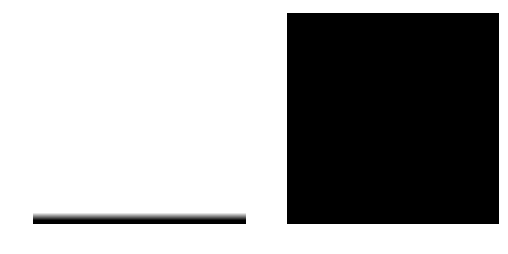

0.999955511623 307 914
8 8


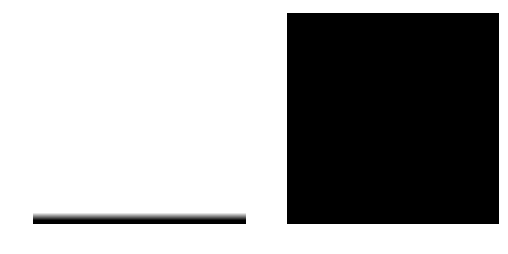

0.999955511623 307 965
8 8


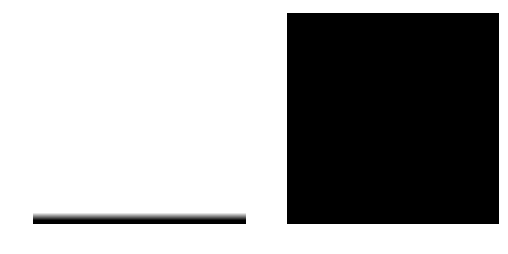

1.0 373 383
8 8


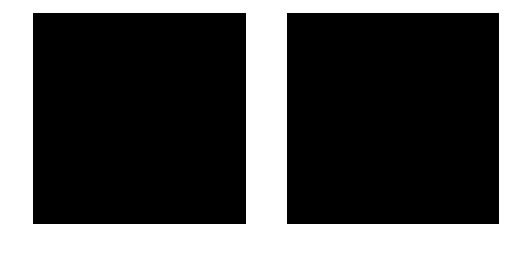

1.0 373 393
8 8


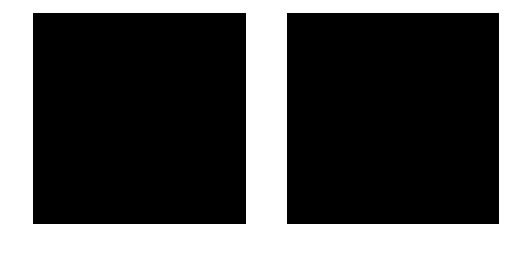

1.0 373 407
8 8


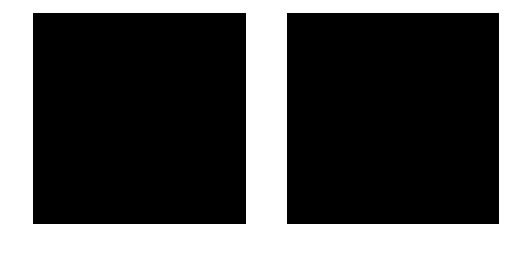

0.9995375406 373 625
8 8


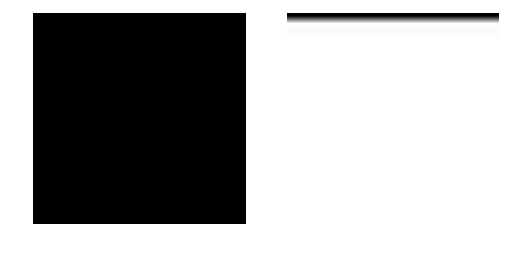

1.0 373 640
8 8


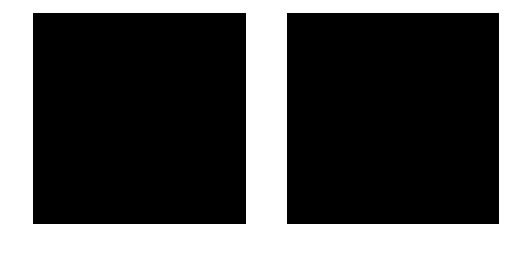

1.0 373 672
8 8


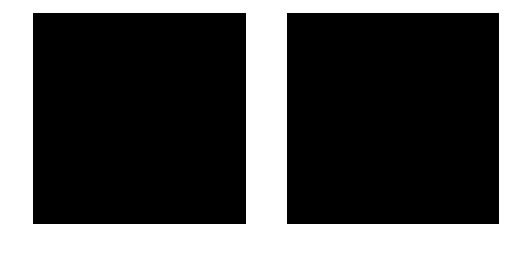

1.0 373 709
8 8


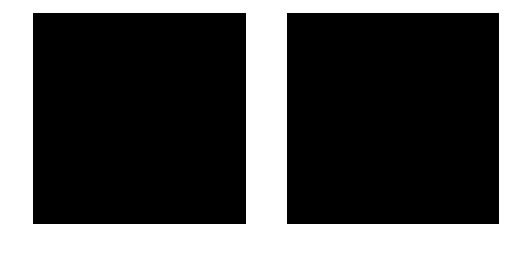

1.0 373 745
8 8


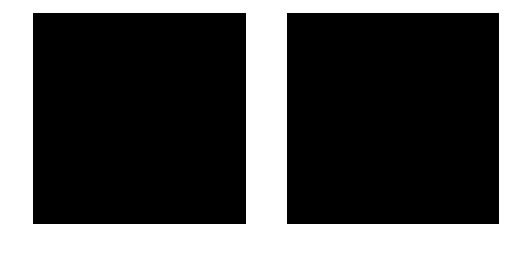

1.0 373 780
8 8


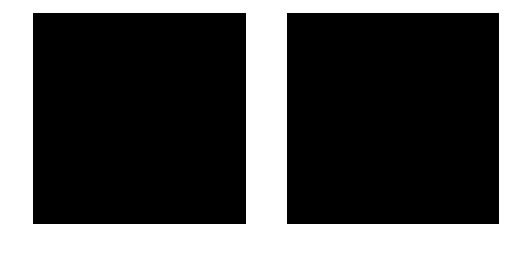

1.0 373 914
8 8


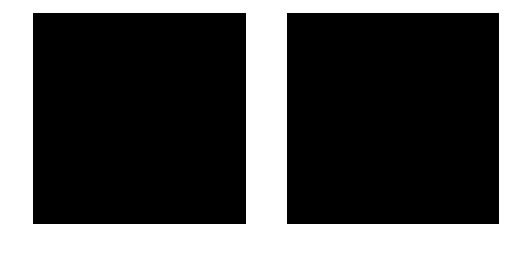

1.0 373 965
8 8


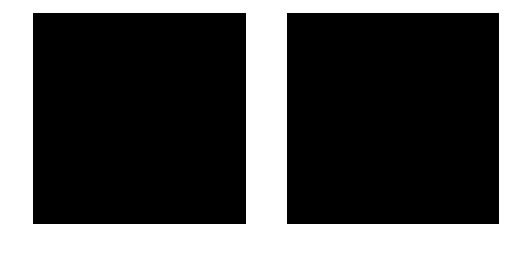

1.0 383 393
8 8


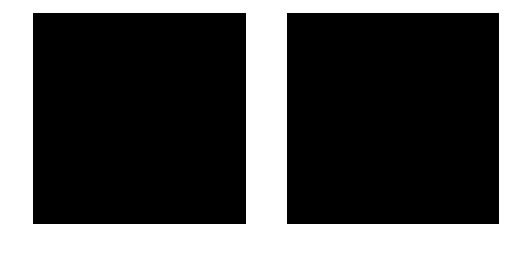

1.0 383 407
8 8


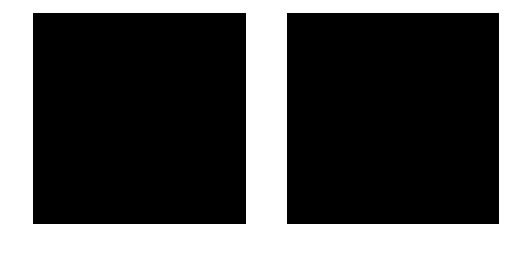

0.9995375406 383 625
8 8


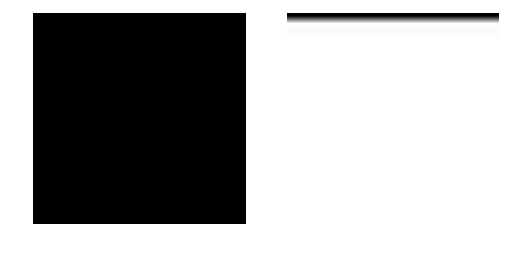

1.0 383 640
8 8


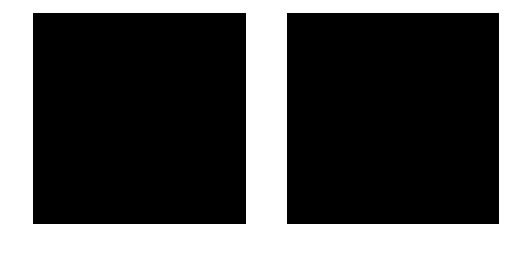

1.0 383 672
8 8


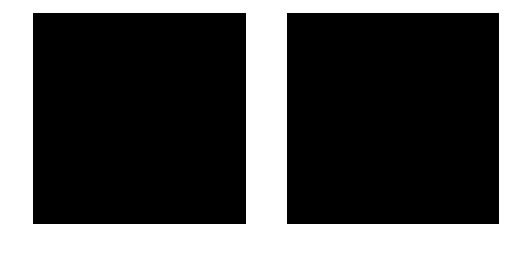

1.0 383 709
8 8


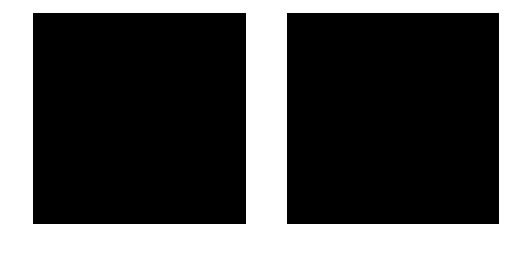

1.0 383 745
8 8


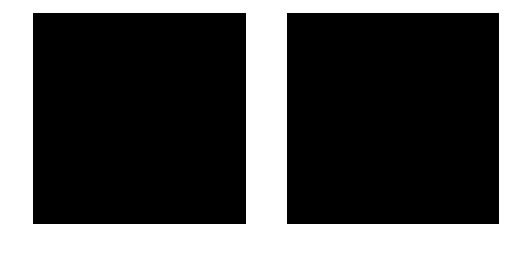

1.0 383 780
8 8


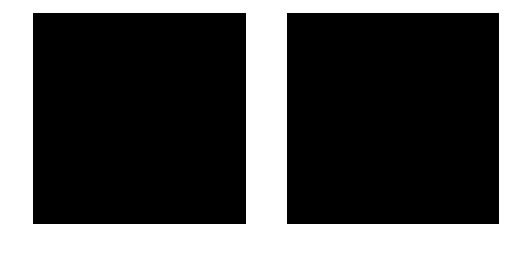

1.0 383 914
8 8


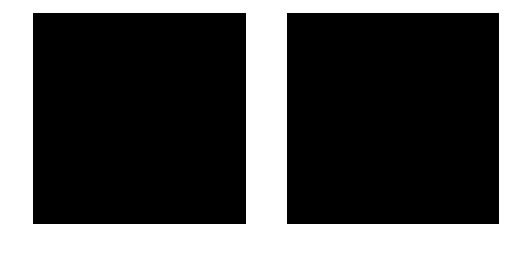

1.0 383 965
8 8


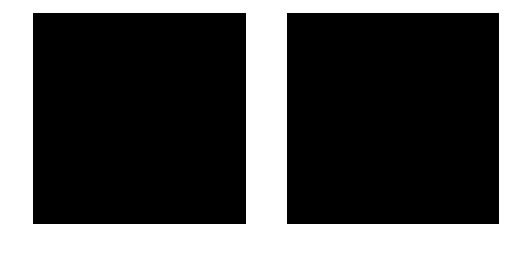

1.0 393 407
8 8


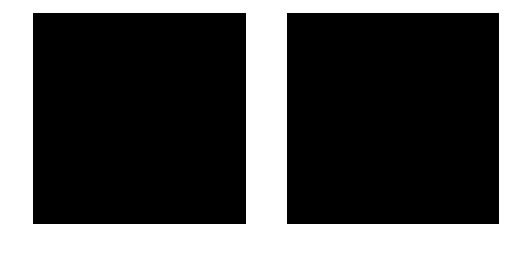

0.9995375406 393 625
8 8


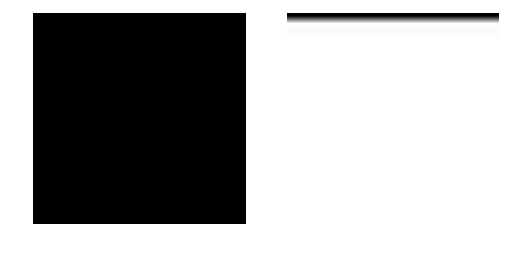

1.0 393 640
8 8


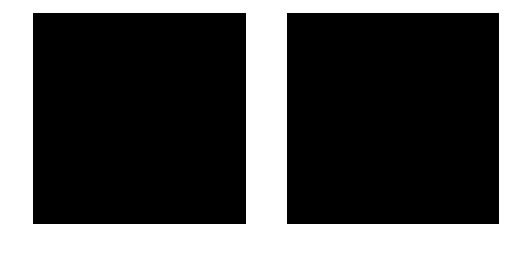

1.0 393 672
8 8


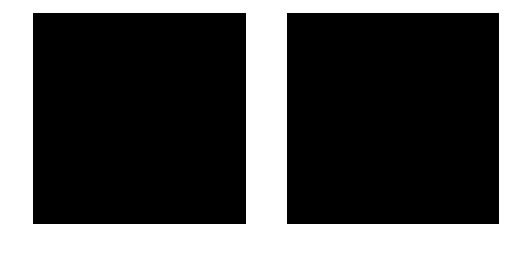

1.0 393 709
8 8


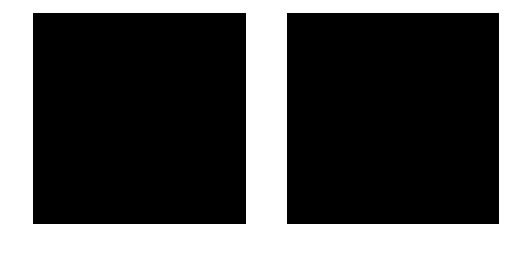

1.0 393 745
8 8


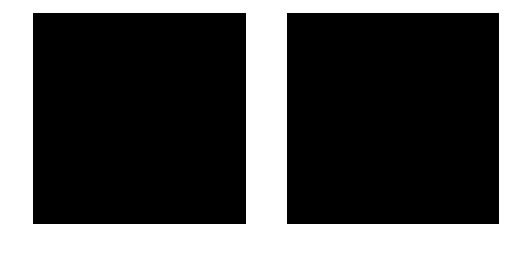

1.0 393 780
8 8


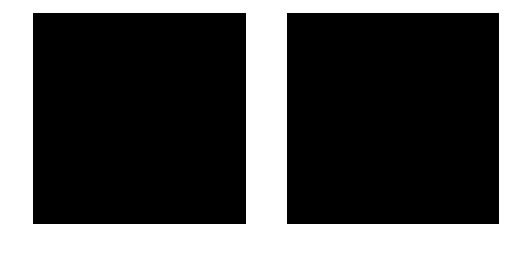

1.0 393 914
8 8


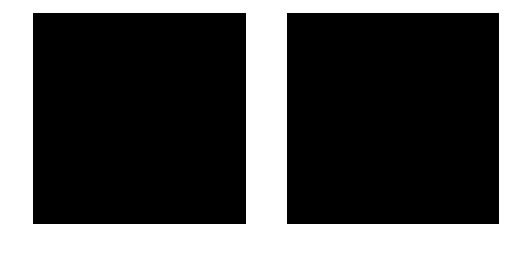

1.0 393 965
8 8


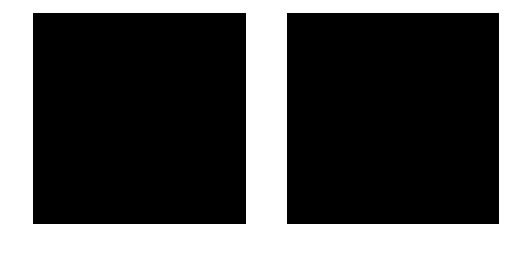

0.9995375406 407 625
8 8


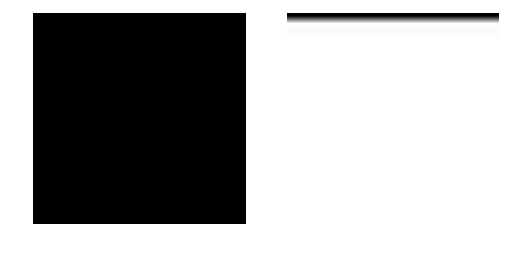

1.0 407 640
8 8


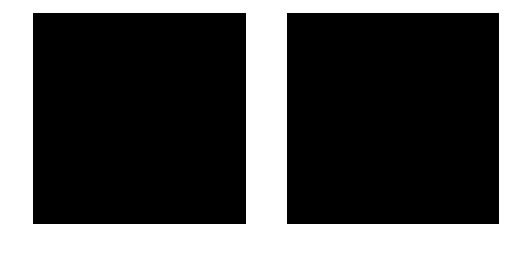

1.0 407 672
8 8


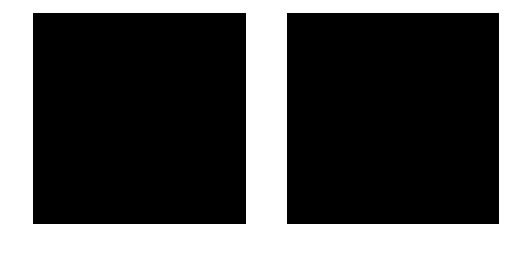

1.0 407 709
8 8


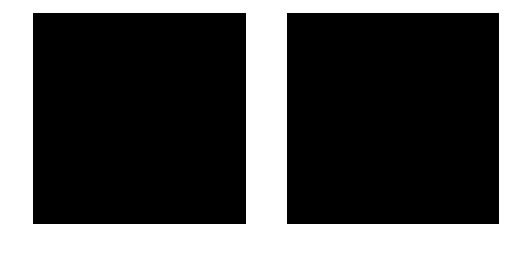

1.0 407 745
8 8


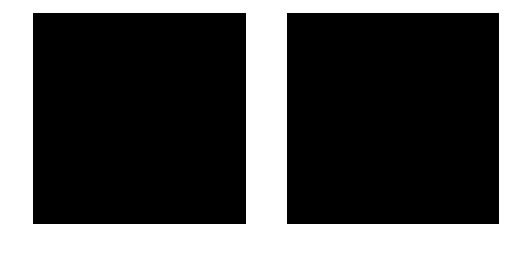

1.0 407 780
8 8


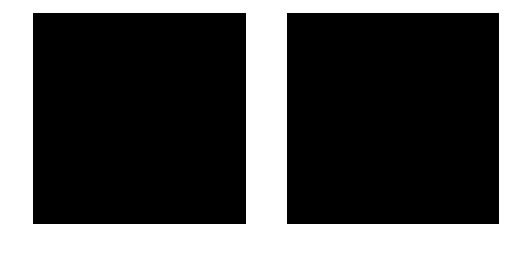

1.0 407 914
8 8


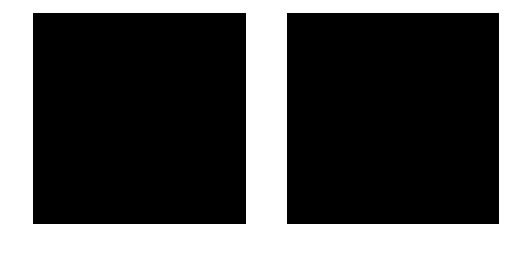

1.0 407 965
8 8


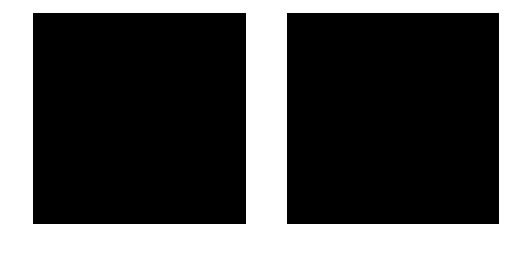

0.999692916346 469 718
0 0


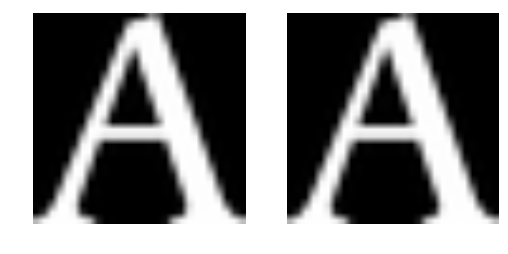

0.991842638701 491 726
8 8


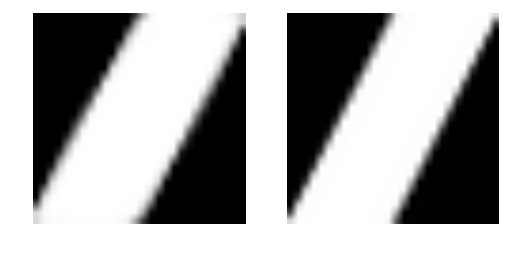

0.991581397131 491 900
8 8


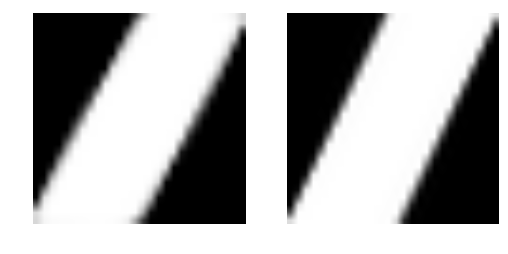

0.995438900311 522 686
9 9


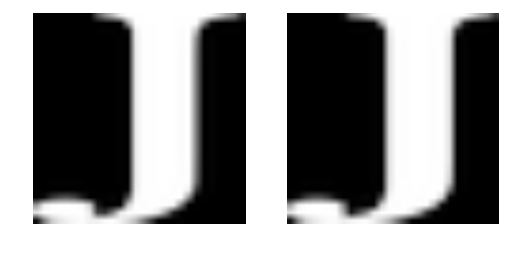

0.995859991759 581 834
7 7


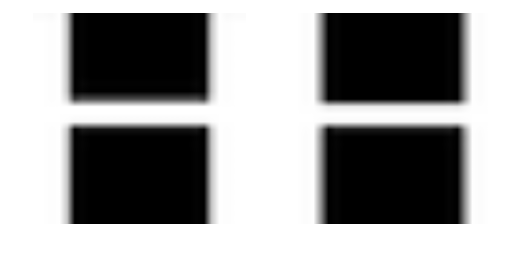

0.9995375406 625 640
8 8


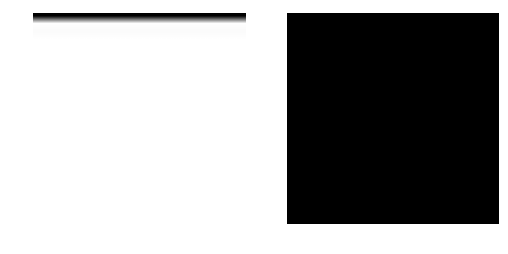

0.9995375406 625 672
8 8


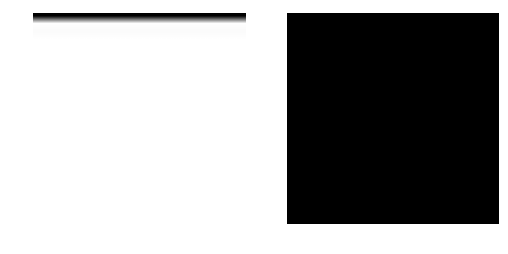

0.9995375406 625 709
8 8


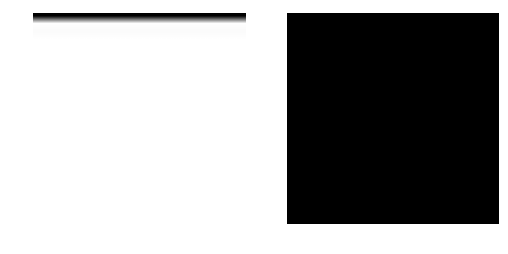

0.9995375406 625 745
8 8


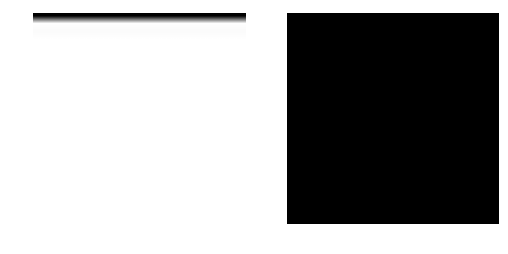

0.9995375406 625 780
8 8


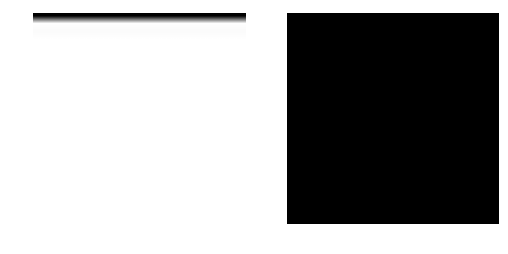

0.9995375406 625 914
8 8


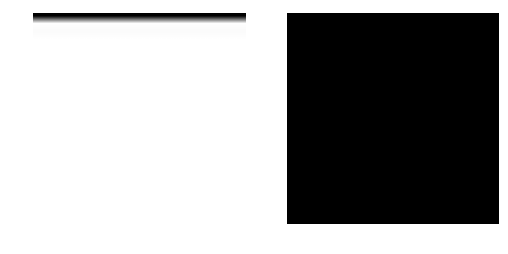

0.9995375406 625 965
8 8


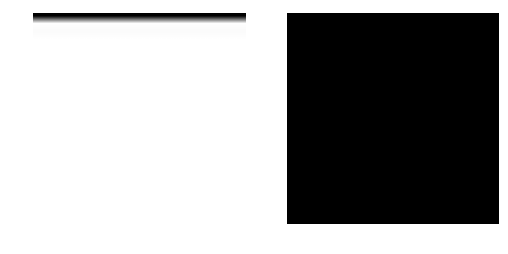

1.0 640 672
8 8


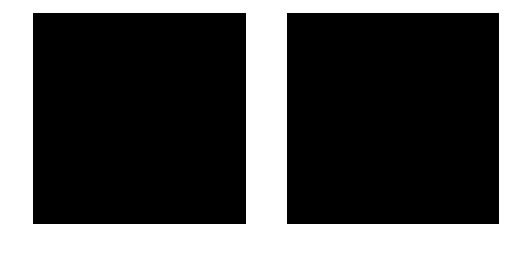

1.0 640 709
8 8


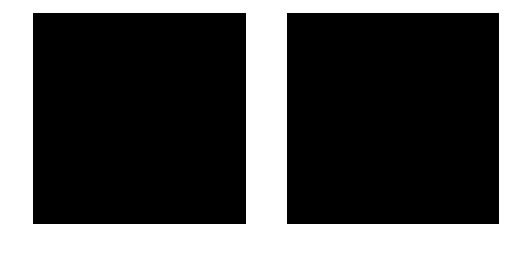

1.0 640 745
8 8


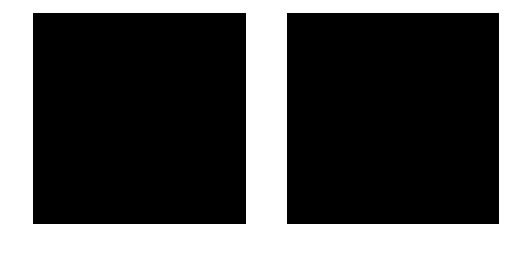

1.0 640 780
8 8


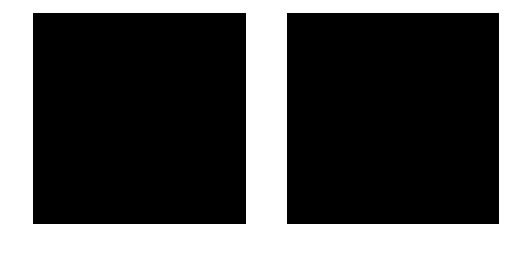

1.0 640 914
8 8


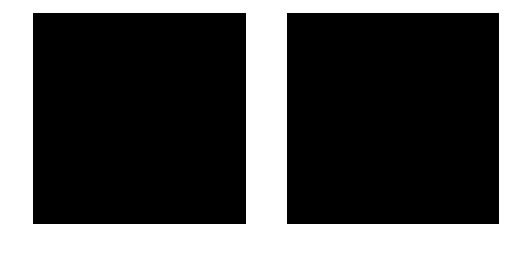

1.0 640 965
8 8


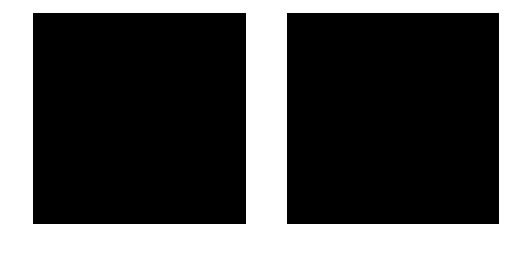

0.996789323399 642 703
9 9


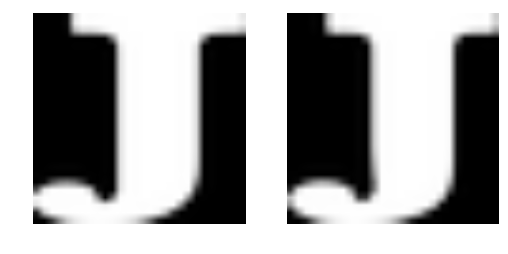

1.0 672 709
8 8


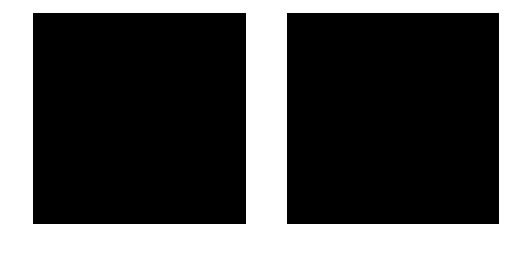

1.0 672 745
8 8


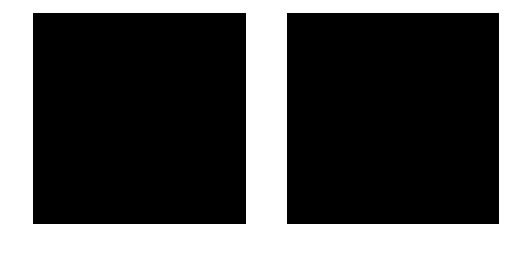

1.0 672 780
8 8


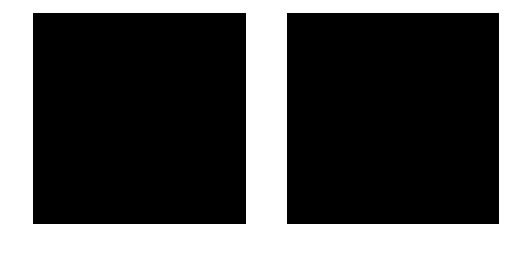

1.0 672 914
8 8


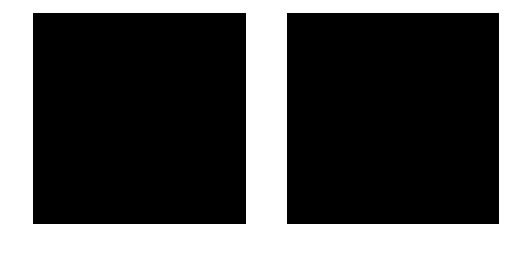

1.0 672 965
8 8


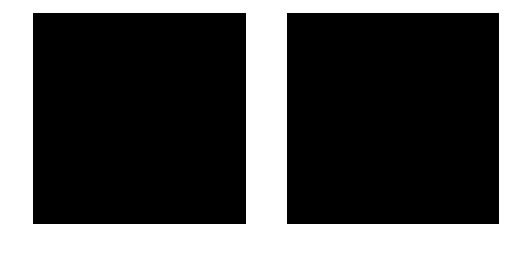

1.0 709 745
8 8


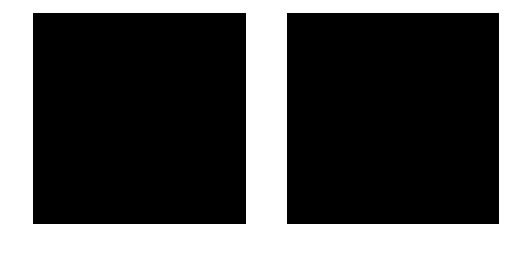

1.0 709 780
8 8


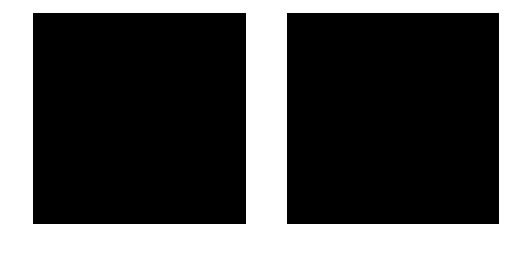

1.0 709 914
8 8


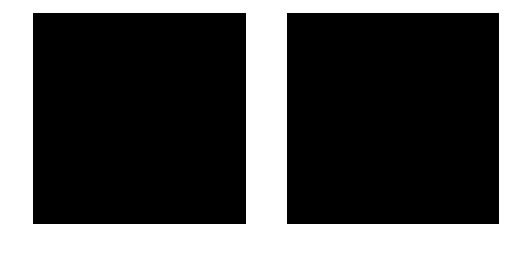

1.0 709 965
8 8


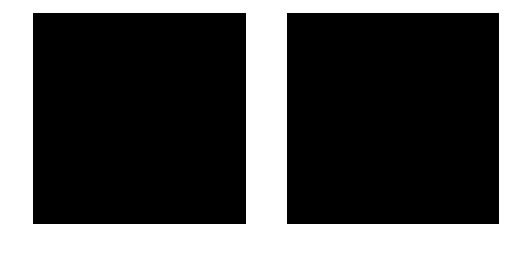

0.990373717621 726 900
8 8


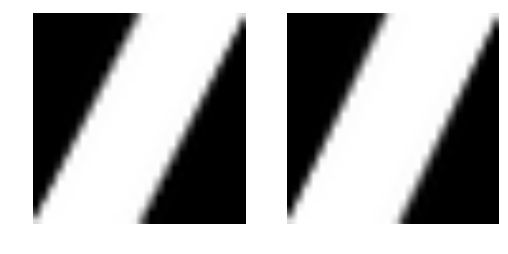

1.0 745 780
8 8


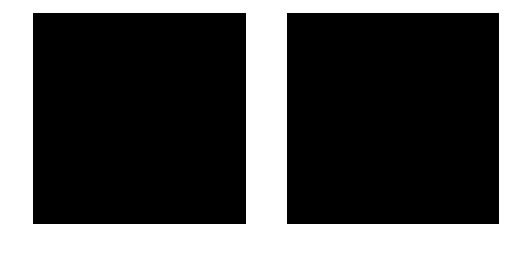

1.0 745 914
8 8


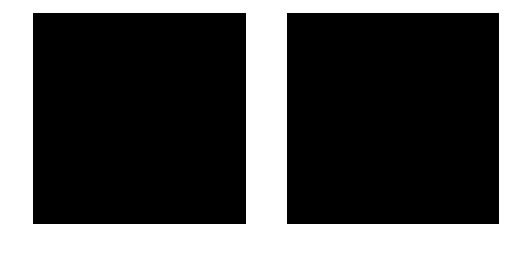

1.0 745 965
8 8


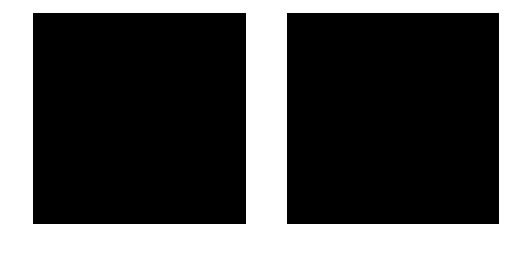

1.0 780 914
8 8


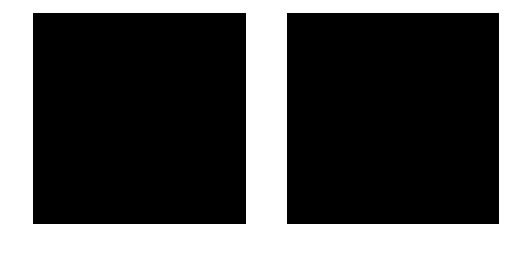

1.0 780 965
8 8


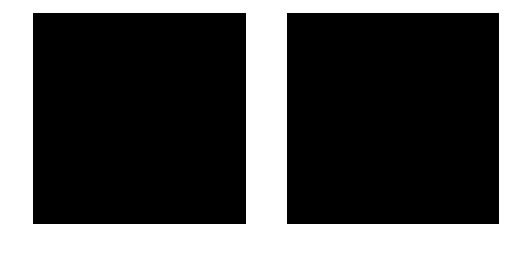

1.0 914 965
8 8


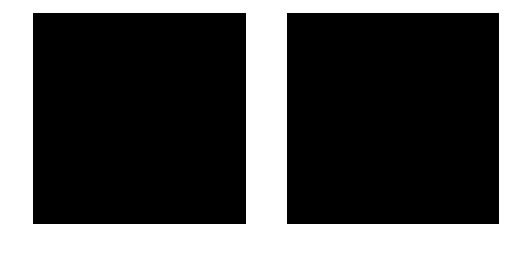

In [61]:
def similarity_of_lettes(a, b):
    return 1 - ((a - b) ** 2).mean()

n = 1000
for i in range(n):
    a = test_dataset[i]
    for j in range(i + 1, n):
        b = test_dataset[j]
        similarity = similarity_of_lettes(a, b)
        if(similarity > 0.99):
            print(similarity, i, j)
            print(test_labels[i], test_labels[j])
            show_letters((a, b))
            

---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---